In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dis
from tqdm import tqdm

import numpy as np
from torch.utils.data import Dataset, TensorDataset, ConcatDataset, Subset, DataLoader


In [2]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## MGVAE

In [4]:
def kl_estimated_loss(
    z, mu_minor, logvar_minor, mu_major, logvar_major, device: str, reduce: bool
):
    """Calculate KL loss using MC estimation."""
    B, m = mu_minor.shape
    N, _ = mu_major.shape

    q = dis.MultivariateNormal(mu_minor, logvar_minor.exp().diag_embed())
    # z.shape is (B, m)
    # define: ratio = prior_pdf / encoder_pdf
    # estimate kl per (mu(x-), logvar(x-)) by the sample mean of (ratio - 1) - log_ratio
    prior = dis.MultivariateNormal(mu_major, logvar_major.exp() * torch.eye(m).to(device))
    p_log_prob = prior.log_prob(z[:, None, :].repeat(1, N, 1))
    mg_p_log_prob = p_log_prob.logsumexp(dim=1) - torch.tensor(N).log().to(device)

    log_ratio = mg_p_log_prob - q.log_prob(z)
    # log_ratio.shape = (B,)
    kl_est = (log_ratio.exp() - 1) - log_ratio

    return kl_est.mean() if reduce else kl_est


def kl_ub_loss(mu_minor, logvar_minor, mu_major, logvar_major, reduce: bool):
    """Calculate KL loss's upper bound using another Jensen's Inequality."""
    B, m = mu_minor.shape
    N, _ = mu_major.shape

    mu_minor = mu_minor.T[None, :, :].repeat(N, 1, 1)
    mu_major = mu_major[:, :, None].repeat(1, 1, B)
    kl_variant = (
        0.5 * ((mu_minor - mu_major) ** 2).sum(dim=1).mean(dim=0) / logvar_major.exp()
    )

    kl_invariant = 0.5 * (
        m * logvar_major
        - logvar_minor.sum(dim=1)
        - m
        + logvar_minor.exp().sum(dim=1) / logvar_major.exp()
    )

    kl = kl_invariant + kl_variant

    return kl.mean() if reduce else kl


def kl_lb_loss(mu_minor, logvar_minor, mu_major, logvar_major, device: str, min_k: int, reduce: bool):
    """Calculate KL loss's lower bound using the 'closest' k majority sample"""
    B, m = mu_minor.shape
    N, _ = mu_major.shape

    _mu_minor = mu_minor[None, :, :].repeat(N, 1, 1)
    _logvar_minor = logvar_minor[None, :, :].repeat(N, 1, 1)
    _mu_major = mu_major[:, None, :].repeat(1, B, 1)
    kl_mat = dis.kl.kl_divergence(
        dis.MultivariateNormal(_mu_minor, torch.diag_embed(_logvar_minor.exp())),
        dis.MultivariateNormal(_mu_major, logvar_major.exp() * torch.eye(m).to(device)),
    )
    _, idx = torch.topk(-kl_mat, k=min_k, dim=0)
    kl_mink = kl_mat.gather(dim=0, index=idx)

    return kl_mink.mean() if reduce else kl_mink.mean(dim=0)


def mgvae_loss(
    x_reconstr,
    x,
    z,
    mu_minor,
    logvar_minor,
    mu_major,
    logvar_major,
    kl_loss_fn: str,
    device: str,
    min_k: int = 128,
    reduce: bool = True,
):
    """
    Calculate the two parts of the loss objective.

    `reduce` (reduction by mean) is set to `True` by default.
    One would set it to `False` for calculating fisher information in EWC.
    """
    n_dims = len(x.shape)
    _reconstruction_loss = F.mse_loss(x_reconstr, x, reduction="none").sum(
        dim=list(range(n_dims))[1:]
    )
    reconstruction_loss = (
        _reconstruction_loss.mean() if reduce else _reconstruction_loss
    )

    match kl_loss_fn:
        case "estimated":
            kl_regularization = kl_estimated_loss(
                z, mu_minor, logvar_minor, mu_major, logvar_major, device, reduce
            )
        case "upper_bound":
            kl_regularization = kl_ub_loss(
                mu_minor, logvar_minor, mu_major, logvar_major, reduce
            )
        case "lower_bound":
            kl_regularization = kl_lb_loss(
                mu_minor, logvar_minor, mu_major, logvar_major, device, min_k, reduce
            )
        case _:
            raise ValueError("incorrect 'kl_loss_fn' value.")
    return reconstruction_loss, kl_regularization


class MGVAE(nn.Module):
    """Majority-Guided VAE."""

    def __init__(
        self,
        input_dim,
        hidden_dim,
        latent_dim,
        majority_data: Dataset,
        N_maj: int,
        device,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.majority_data = majority_data
        self.N_maj = N_maj
        self.device = device

        self.logvar_major = nn.Parameter(torch.tensor(1.0))

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std)
        z = mu + std * noise
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z

    def compute_mg_prior_mu(self):
        """Calculate a majority guided prior using a sub-sample of the majority set."""
        majority_data = self.majority_data
        majority_dl = DataLoader(
            Subset(
                majority_data,
                np.random.choice(len(majority_data), self.N_maj, replace=False),
            ),
            batch_size=128,
            shuffle=True,
        )
        mu_major = torch.zeros(self.N_maj, self.latent_dim).to(self.device)
        idx_cursor = 0
        with torch.no_grad():
            for X_batch, _ in majority_dl:
                X_batch = X_batch.view(-1, self.input_dim).to(self.device)
                mu_batch, _ = self.encode(X_batch)
                mu_major[idx_cursor : (idx_cursor + len(X_batch)), :] = mu_batch
                idx_cursor += len(X_batch)
        return mu_major

    def finetune(
        self, train_loader: DataLoader, kl_loss_fn: str, ewc_lambda, lr, epochs, verbose_period
    ):
        """
        Fine-tuning with EWC.

        `kl_loss_fn` is in {`upper_bound`, `estimated`}.
        """
        print("finetuning starts:")
        # Fisher information calculated based on the pre-trained model
        if ewc_lambda > 0:
            ewc = EWC(self, self.majority_data, kl_loss_fn, self.device)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            total_recon_loss, total_kl_loss, total_ewc_loss = 0., 0., 0.
            total_loss = 0.
            total_batch = 0.
            verbose = (epoch % verbose_period) == 0
            with tqdm(
                train_loader, unit="batch", mininterval=0, disable=not verbose
            ) as bar:
                bar.set_description(f"Epoch {epoch}")
                for X_batch, _ in bar:
                    X_batch = X_batch.view(-1, self.input_dim).to(self.device)
                    optimizer.zero_grad()
                    Xh_batch, mu_batch, logvar_batch, z_batch = self(X_batch)
                    # get a sub-sample of majorities to compute prior
                    mu_major = self.compute_mg_prior_mu()
                    recon_loss, kl_loss = mgvae_loss(
                        Xh_batch,
                        X_batch,
                        z_batch,
                        mu_batch,
                        logvar_batch,
                        mu_major,
                        self.logvar_major,
                        kl_loss_fn,
                        self.device,
                    )
                    if ewc_lambda > 0:
                        ewc_loss = ewc.penalty(self)
                    else:
                        ewc_loss = torch.tensor(0.).to(self.device)
                    loss = recon_loss + kl_loss + ewc_lambda * ewc_loss

                    loss.backward()
                    optimizer.step()
                    # update progress
                    total_recon_loss += recon_loss.item()
                    total_kl_loss += kl_loss.item()
                    total_ewc_loss += ewc_loss.item()
                    total_loss += loss.item()
                    total_batch += 1

                    bar.set_postfix(
                        recon_loss=float(total_recon_loss / total_batch),
                        kl_loss=float(total_kl_loss / total_batch),
                        ewc_loss=float(total_ewc_loss / total_batch),
                        total=float(total_loss / total_batch)
                    )
            if verbose:
                print(self.logvar_major.data)

    def pretrain(
        self,
        train_loader: DataLoader,
        kl_loss_fn: str,
        lr,
        epochs,
        verbose_period,
    ):
        """
        Pre-training.

        `kl_loss_fn` is in {`upper_bound`, `estimated`}.
        """
        print("pre-training starts:")
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            total_recon_loss, total_kl_loss = 0., 0.
            total_loss = 0.
            total_batch = 0.
            verbose = (epoch % verbose_period) == 0
            with tqdm(
                train_loader, unit="batch", mininterval=0, disable=not verbose
            ) as bar:
                bar.set_description(f"Epoch {epoch}")
                for X_batch, _ in bar:
                    X_batch = X_batch.view(-1, self.input_dim).to(self.device)
                    optimizer.zero_grad()
                    Xh_batch, mu_batch, logvar_batch, z_batch = self(X_batch)
                    # get a sub-sample of majorities to compute prior
                    mu_major = self.compute_mg_prior_mu()
                    recon_loss, kl_loss = mgvae_loss(
                        Xh_batch,
                        X_batch,
                        z_batch,
                        mu_batch,
                        logvar_batch,
                        mu_major,
                        self.logvar_major,
                        kl_loss_fn,
                        self.device,
                    )
                    loss = recon_loss + kl_loss
                    loss.backward()
                    optimizer.step()
                    # update progress
                    total_recon_loss += recon_loss.item()
                    total_kl_loss += kl_loss.item()
                    total_loss += loss.item()
                    total_batch += 1

                    bar.set_postfix(
                        recon_loss=float(total_recon_loss / total_batch),
                        kl_loss=float(total_kl_loss / total_batch),
                        total=float(total_loss / total_batch)
                    )
            if verbose:
                print(self.logvar_major.data)


## EWC

In [5]:
class EWC:
    """Elastic Weight Consolidation (specific to the MGVAE model)."""

    def __init__(
        self,
        model: MGVAE,
        dataset: TensorDataset,
        kl_loss_fn: str,
        device: str,
        N: int = 200,
    ) -> None:
        """
        Initialize an elastic weight consolidation object.

        The dataset (old task) used in the init will be downsampled and used to calculate the Monte Carlo estimates for Fisher Information.
        The param importance calculated based on the data from the "old task"
        """
        self.model = model
        self.dataset = dataset
        self.device = device
        self.params_old = dict()
        for n, p in self.model.named_parameters():
            self.params_old[n] = p.clone()
        self.fisher_information: dict = self._compute_fisher(kl_loss_fn, N)

    def _compute_fisher(self, kl_loss_fn: str, N):
        """Calculate diagonal elements in the information matrix."""
        # retrieve a subset data
        sample_dataset = Subset(
            self.dataset, np.random.choice(len(self.dataset), N, replace=False)
        )
        x = (
            torch.tensor(sample_dataset[:][0])
            .view(-1, self.model.input_dim)
            .to(self.device)
        )
        # foward pass using mgvae_loss
        xh, mu, logvar, z = self.model(x)
        recon_loss, kl_loss = mgvae_loss(
            xh,
            x,
            z,
            mu,
            logvar,
            self.model.compute_mg_prior_mu(),
            self.model.logvar_major,
            kl_loss_fn=kl_loss_fn,
            device=self.device,
            reduce=False,
        )
        # calculate fisher information using gradients
        fisher_information = dict()
        for n, p in self.model.named_parameters():
            fisher_information[n] = torch.zeros_like(p)
        for i in range(N):
            gradients = torch.autograd.grad(
                recon_loss[i] + kl_loss[i], self.model.parameters(), retain_graph=True
            )
            for j, n in enumerate(self.params_old):
                fisher_information[n] += gradients[j] ** 2 / N

        return fisher_information

    def penalty(self, updated_model: nn.Module):
        """Sum over all F(param_new - param_old)^2."""
        loss = 0
        for n, param_new in updated_model.named_parameters():
            loss += (
                self.fisher_information[n] * (param_new - self.params_old[n]) ** 2
            ).sum()
        return loss


## Utils

In [6]:
def normalize(x: torch.Tensor):
    """Normalize pixel values to the range of 0-1."""
    return x / 255


def generate_imbalanced_dataset(
    dataset: Dataset, rho: float, transform_fn, rule: int = 5
) -> Dataset:
    """Create an imbalanced version of a standard dataset e.g. MNIST."""
    majority_idx = dataset.targets < rule
    majority_size = majority_idx.sum().item()
    minority_size = (~majority_idx).sum().item()
    majority = TensorDataset(
        transform_fn(dataset.data[majority_idx]), torch.zeros(majority_size)
    )
    minority = TensorDataset(
        transform_fn(dataset.data[~majority_idx]), torch.ones(minority_size)
    )

    if majority_size / minority_size < rho:
        minority = Subset(
            minority,
            np.random.choice(minority_size, int(majority_size / rho), replace=False),
        )

    imbalanced_dataset = ConcatDataset([majority, minority])
    print(f"majority size: {len(majority)}, minority size: {len(minority)}")
    return imbalanced_dataset


## Implement

### Data

In [7]:
%%capture
import torchvision
from torchvision import transforms

train = torchvision.datasets.MNIST("../mnist/", download=True, train=True)
test = torchvision.datasets.MNIST("../mnist/", download=True, train=False)

In [8]:
train_imbalanced = generate_imbalanced_dataset(
    train, rho=10, transform_fn=normalize, rule=5
)

test_imbalanced = generate_imbalanced_dataset(
    test, rho=10, transform_fn=normalize, rule=5
)

majority size: 30596, minority size: 3059
majority size: 5139, minority size: 513


In [9]:
train_imb_dl = DataLoader(train_imbalanced, batch_size=128, shuffle=True)
test_imb_dl = DataLoader(test_imbalanced, batch_size=128, shuffle=False)

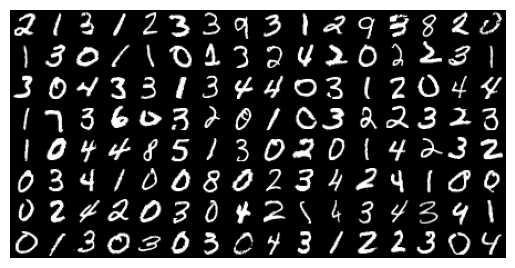

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
X_batch, y_batch = next(iter(train_imb_dl))

X_batch = X_batch.view(-1, 1, 28, 28)

plt.imshow(
    torch.permute(make_grid(X_batch, nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

print(y_batch.view(-1, 16).numpy())

In [ ]:
majority_data = train_imb_dl.dataset.datasets[0]
minority_data = train_imb_dl.dataset.datasets[1]

In [ ]:
majority_dl = DataLoader(majority_data, batch_size=128, shuffle=True)
minority_dl = DataLoader(minority_data, batch_size=128, shuffle=True)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


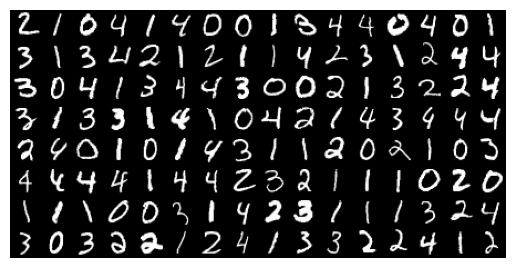

In [ ]:
X_batch, _ = next(iter(DataLoader(test_imb_dl.dataset.datasets[0], batch_size=128, shuffle=False)))

X_batch = X_batch.view(-1, 1, 28, 28)

plt.imshow(
    torch.permute(make_grid(X_batch, nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

### Train with `upper_bound`

#### w/ pretraining

In [ ]:
model = MGVAE(input_dim=784, hidden_dim=128, latent_dim=32, majority_data=majority_data, N_maj=2048, device=device)
model = model.to(device)
model.pretrain(majority_dl, kl_loss_fn="upper_bound", lr=1e-3, epochs=65, verbose_period=4)
model.finetune(minority_dl, kl_loss_fn="upper_bound", ewc_lambda=1e2, lr=1e-3, epochs=221, verbose_period=20)

pre-training starts:


Epoch 0: 100%|██████████| 240/240 [00:10<00:00, 22.76batch/s, kl_loss=6.96, recon_loss=52.4, total=59.3]


tensor(1.1837, device='cuda:0')


Epoch 4: 100%|██████████| 240/240 [00:10<00:00, 23.48batch/s, kl_loss=11, recon_loss=24, total=35]


tensor(2.1105, device='cuda:0')


Epoch 8: 100%|██████████| 240/240 [00:10<00:00, 22.31batch/s, kl_loss=11.6, recon_loss=21.3, total=32.9]


tensor(2.9808, device='cuda:0')


Epoch 12: 100%|██████████| 240/240 [00:10<00:00, 22.28batch/s, kl_loss=12, recon_loss=20.1, total=32]


tensor(3.8728, device='cuda:0')


Epoch 16: 100%|██████████| 240/240 [00:10<00:00, 22.60batch/s, kl_loss=12.1, recon_loss=19.3, total=31.4]


tensor(4.7614, device='cuda:0')


Epoch 20: 100%|██████████| 240/240 [00:10<00:00, 23.15batch/s, kl_loss=12.2, recon_loss=18.8, total=31]


tensor(5.6332, device='cuda:0')


Epoch 24: 100%|██████████| 240/240 [00:10<00:00, 23.08batch/s, kl_loss=12.2, recon_loss=18.4, total=30.6]


tensor(6.4775, device='cuda:0')


Epoch 28: 100%|██████████| 240/240 [00:10<00:00, 22.75batch/s, kl_loss=12.2, recon_loss=18.3, total=30.5]


tensor(7.2929, device='cuda:0')


Epoch 32: 100%|██████████| 240/240 [00:10<00:00, 22.43batch/s, kl_loss=12.2, recon_loss=18.2, total=30.3]


tensor(8.0618, device='cuda:0')


Epoch 36: 100%|██████████| 240/240 [00:10<00:00, 23.15batch/s, kl_loss=12.1, recon_loss=18, total=30.1]


tensor(8.7793, device='cuda:0')


Epoch 40: 100%|██████████| 240/240 [00:10<00:00, 23.94batch/s, kl_loss=12.1, recon_loss=17.9, total=30]


tensor(9.4506, device='cuda:0')


Epoch 44: 100%|██████████| 240/240 [00:09<00:00, 24.56batch/s, kl_loss=12.1, recon_loss=17.8, total=29.9]


tensor(10.0639, device='cuda:0')


Epoch 48: 100%|██████████| 240/240 [00:09<00:00, 24.04batch/s, kl_loss=12.1, recon_loss=17.8, total=29.8]


tensor(10.6135, device='cuda:0')


Epoch 52: 100%|██████████| 240/240 [00:10<00:00, 23.81batch/s, kl_loss=12.1, recon_loss=17.7, total=29.8]


tensor(11.1008, device='cuda:0')


Epoch 56: 100%|██████████| 240/240 [00:10<00:00, 23.91batch/s, kl_loss=12.1, recon_loss=17.6, total=29.7]


tensor(11.5410, device='cuda:0')


Epoch 60: 100%|██████████| 240/240 [00:09<00:00, 24.22batch/s, kl_loss=12.1, recon_loss=17.6, total=29.7]


tensor(11.9370, device='cuda:0')


Epoch 64: 100%|██████████| 240/240 [00:10<00:00, 23.93batch/s, kl_loss=12.1, recon_loss=17.5, total=29.6]
<ipython-input-5-a1c7acb54310>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sample_dataset[:][0])


tensor(12.2778, device='cuda:0')
finetuning starts:


Epoch 0: 100%|██████████| 24/24 [00:01<00:00, 19.55batch/s, ewc_loss=0.273, kl_loss=12, recon_loss=36.2, total=75.5]


tensor(12.2858, device='cuda:0')


Epoch 20: 100%|██████████| 24/24 [00:01<00:00, 21.48batch/s, ewc_loss=6.12, kl_loss=11.9, recon_loss=21.4, total=645]


tensor(12.4427, device='cuda:0')


Epoch 40: 100%|██████████| 24/24 [00:01<00:00, 22.07batch/s, ewc_loss=10.6, kl_loss=12.1, recon_loss=20.1, total=1.09e+3]


tensor(12.6434, device='cuda:0')


Epoch 60: 100%|██████████| 24/24 [00:01<00:00, 15.56batch/s, ewc_loss=15, kl_loss=12.3, recon_loss=19.3, total=1.53e+3]


tensor(12.8351, device='cuda:0')


Epoch 80: 100%|██████████| 24/24 [00:01<00:00, 22.17batch/s, ewc_loss=19.4, kl_loss=12.4, recon_loss=18.9, total=1.97e+3]


tensor(13.0187, device='cuda:0')


Epoch 100: 100%|██████████| 24/24 [00:01<00:00, 22.17batch/s, ewc_loss=23.9, kl_loss=12.4, recon_loss=18.3, total=2.42e+3]


tensor(13.1902, device='cuda:0')


Epoch 120: 100%|██████████| 24/24 [00:01<00:00, 16.94batch/s, ewc_loss=28.6, kl_loss=12.6, recon_loss=17.8, total=2.89e+3]


tensor(13.3532, device='cuda:0')


Epoch 140: 100%|██████████| 24/24 [00:01<00:00, 22.38batch/s, ewc_loss=33.3, kl_loss=12.7, recon_loss=17.5, total=3.36e+3]


tensor(13.5066, device='cuda:0')


Epoch 160: 100%|██████████| 24/24 [00:01<00:00, 21.63batch/s, ewc_loss=38.1, kl_loss=12.7, recon_loss=17.3, total=3.84e+3]


tensor(13.6540, device='cuda:0')


Epoch 180: 100%|██████████| 24/24 [00:01<00:00, 22.95batch/s, ewc_loss=43, kl_loss=12.9, recon_loss=17.1, total=4.33e+3]


tensor(13.7945, device='cuda:0')


Epoch 200: 100%|██████████| 24/24 [00:01<00:00, 22.26batch/s, ewc_loss=48.2, kl_loss=12.9, recon_loss=16.9, total=4.85e+3]


tensor(13.9296, device='cuda:0')


Epoch 220: 100%|██████████| 24/24 [00:01<00:00, 21.72batch/s, ewc_loss=53.4, kl_loss=13, recon_loss=16.9, total=5.37e+3]

tensor(14.0586, device='cuda:0')


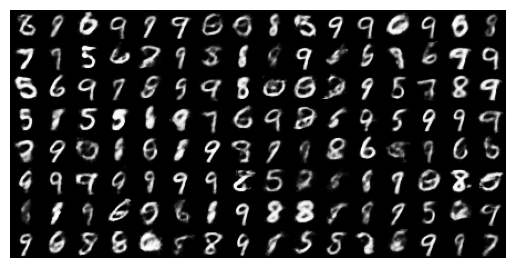

In [ ]:
Xh_batch, _, _, _ = model(X_batch.view(-1, 784).to(device))

plt.imshow(
    torch.permute(make_grid(Xh_batch.detach().cpu().view(-1, 1, 28, 28), nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

#### w/o pretrain

In [ ]:
model = MGVAE(input_dim=784, hidden_dim=128, latent_dim=32, majority_data=majority_data, N_maj=2048, device=device)
model = model.to(device)
model.finetune(minority_dl, kl_loss_fn="upper_bound", ewc_lambda=0, lr=1e-3, epochs=221, verbose_period=20)

finetuning starts:


Epoch 220: 100%|██████████| 24/24 [00:01<00:00, 17.78batch/s, ewc_loss=0, kl_loss=12.4, recon_loss=17.5, total=29.9]


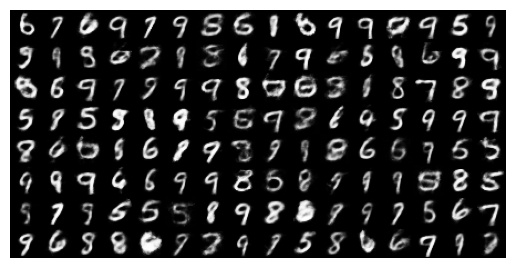

In [ ]:
Xh_batch, _, _ = model(X_batch.view(-1, 784).to(device))
plt.imshow(
    torch.permute(make_grid(Xh_batch.detach().cpu().view(-1, 1, 28, 28), nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

### Train with `estimated`

#### w/ pre-train

In [ ]:
model = MGVAE(input_dim=784, hidden_dim=128, latent_dim=32, majority_data=majority_data, N_maj=2048, device=device)
model = model.to(device)
torch.autograd.set_detect_anomaly(True)
model.pretrain(majority_dl, kl_loss_fn="estimated", lr=1e-3, epochs=33, verbose_period=4)
model.finetune(minority_dl, kl_loss_fn="estimated", ewc_lambda=5e4, lr=1e-3, epochs=221, verbose_period=20)

pre-training starts:


Epoch 0: 100%|██████████| 240/240 [00:23<00:00, 10.21batch/s, kl_loss=2.46, recon_loss=52.2, total=54.6]


tensor(0.8905, device='cuda:0')


Epoch 4: 100%|██████████| 240/240 [00:25<00:00,  9.57batch/s, kl_loss=5.65, recon_loss=24.4, total=30.1]


tensor(0.7754, device='cuda:0')


Epoch 8: 100%|██████████| 240/240 [00:23<00:00, 10.15batch/s, kl_loss=6.75, recon_loss=21.8, total=28.5]


tensor(1.0328, device='cuda:0')


Epoch 12: 100%|██████████| 240/240 [00:23<00:00, 10.14batch/s, kl_loss=7.24, recon_loss=20.8, total=28]


tensor(1.2771, device='cuda:0')


Epoch 16: 100%|██████████| 240/240 [00:23<00:00, 10.25batch/s, kl_loss=7.33, recon_loss=20, total=27.3]


tensor(1.5590, device='cuda:0')


Epoch 20: 100%|██████████| 240/240 [00:22<00:00, 10.71batch/s, kl_loss=7.48, recon_loss=19.5, total=27]


tensor(1.9757, device='cuda:0')


Epoch 24: 100%|██████████| 240/240 [00:23<00:00, 10.15batch/s, kl_loss=8.2, recon_loss=19.4, total=27.6]


tensor(2.3627, device='cuda:0')


Epoch 28: 100%|██████████| 240/240 [00:22<00:00, 10.46batch/s, kl_loss=7.75, recon_loss=18.9, total=26.6]


tensor(2.6382, device='cuda:0')


Epoch 32: 100%|██████████| 240/240 [00:23<00:00, 10.02batch/s, kl_loss=7.94, recon_loss=18.5, total=26.4]


tensor(2.9293, device='cuda:0')
finetuning starts:


Epoch 0: 100%|██████████| 24/24 [00:03<00:00,  6.27batch/s, ewc_loss=0.248, kl_loss=10.9, recon_loss=34.8, total=1.24e+4]


tensor(2.9530, device='cuda:0')


Epoch 20: 100%|██████████| 24/24 [00:03<00:00,  6.14batch/s, ewc_loss=18.9, kl_loss=8.97, recon_loss=22.7, total=9.44e+5]


tensor(3.2779, device='cuda:0')


Epoch 40: 100%|██████████| 24/24 [00:03<00:00,  6.27batch/s, ewc_loss=41.7, kl_loss=9.34, recon_loss=21.1, total=2.09e+6]


tensor(3.5757, device='cuda:0')


Epoch 60: 100%|██████████| 24/24 [00:03<00:00,  6.06batch/s, ewc_loss=68.5, kl_loss=9.57, recon_loss=20.1, total=3.42e+6]


tensor(3.8956, device='cuda:0')


Epoch 80: 100%|██████████| 24/24 [00:03<00:00,  6.75batch/s, ewc_loss=97.5, kl_loss=9.8, recon_loss=19.5, total=4.88e+6]


tensor(4.2116, device='cuda:0')


Epoch 100: 100%|██████████| 24/24 [00:03<00:00,  7.11batch/s, ewc_loss=131, kl_loss=9.78, recon_loss=19, total=6.56e+6]


tensor(4.5262, device='cuda:0')


Epoch 120: 100%|██████████| 24/24 [00:03<00:00,  7.37batch/s, ewc_loss=172, kl_loss=9.89, recon_loss=18.8, total=8.59e+6]


tensor(4.8384, device='cuda:0')


Epoch 140: 100%|██████████| 24/24 [00:03<00:00,  7.34batch/s, ewc_loss=219, kl_loss=9.96, recon_loss=18.4, total=1.09e+7]


tensor(5.1512, device='cuda:0')


Epoch 160: 100%|██████████| 24/24 [00:03<00:00,  7.43batch/s, ewc_loss=271, kl_loss=9.96, recon_loss=18.2, total=1.35e+7]


tensor(5.4414, device='cuda:0')


Epoch 180: 100%|██████████| 24/24 [00:03<00:00,  7.39batch/s, ewc_loss=320, kl_loss=10.1, recon_loss=18, total=1.6e+7]


tensor(5.6676, device='cuda:0')


Epoch 200: 100%|██████████| 24/24 [00:03<00:00,  7.38batch/s, ewc_loss=375, kl_loss=10.2, recon_loss=17.7, total=1.88e+7]


tensor(5.9163, device='cuda:0')


Epoch 220: 100%|██████████| 24/24 [00:03<00:00,  7.54batch/s, ewc_loss=436, kl_loss=10.1, recon_loss=17.6, total=2.18e+7]

tensor(6.1643, device='cuda:0')


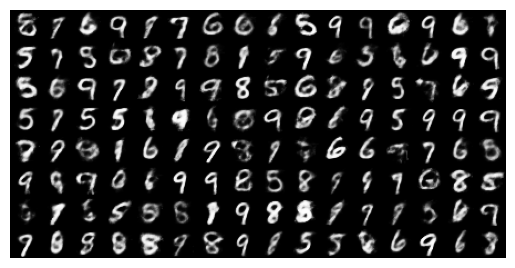

In [ ]:
Xh_batch, _, _, _ = model(X_batch.view(-1, 784).to(device))

plt.imshow(
    torch.permute(make_grid(Xh_batch.detach().cpu().view(-1, 1, 28, 28), nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

#### w/o pre-train

In [ ]:
model = MGVAE(input_dim=784, hidden_dim=128, latent_dim=32, majority_data=majority_data, N_maj=2048, device=device)
model = model.to(device)
model.finetune(minority_dl, kl_loss_fn="estimated", ewc_lambda=0, lr=1e-3, epochs=101, verbose_period=5)

finetuning starts:


Epoch 0: 100%|██████████| 24/24 [00:02<00:00, 11.23batch/s, ewc_loss=0, kl_loss=3.02, recon_loss=125, total=128]


tensor(0.9793, device='cuda:0')


Epoch 5: 100%|██████████| 24/24 [00:02<00:00, 11.27batch/s, ewc_loss=0, kl_loss=3.39, recon_loss=41, total=44.4]


tensor(0.9398, device='cuda:0')


Epoch 10: 100%|██████████| 24/24 [00:02<00:00,  9.05batch/s, ewc_loss=0, kl_loss=3.97, recon_loss=35.9, total=39.8]


tensor(0.9056, device='cuda:0')


Epoch 15: 100%|██████████| 24/24 [00:01<00:00, 12.13batch/s, ewc_loss=0, kl_loss=3.82, recon_loss=33.5, total=37.3]


tensor(0.8755, device='cuda:0')


Epoch 20: 100%|██████████| 24/24 [00:01<00:00, 12.12batch/s, ewc_loss=0, kl_loss=4.2, recon_loss=31.9, total=36.1]


tensor(0.8554, device='cuda:0')


Epoch 25: 100%|██████████| 24/24 [00:01<00:00, 12.05batch/s, ewc_loss=0, kl_loss=4.53, recon_loss=30.7, total=35.3]


tensor(0.8375, device='cuda:0')


Epoch 30: 100%|██████████| 24/24 [00:02<00:00, 10.72batch/s, ewc_loss=0, kl_loss=4.91, recon_loss=29.6, total=34.5]


tensor(0.8241, device='cuda:0')


Epoch 35: 100%|██████████| 24/24 [00:02<00:00,  9.41batch/s, ewc_loss=0, kl_loss=5.17, recon_loss=28.6, total=33.8]


tensor(0.8107, device='cuda:0')


Epoch 40: 100%|██████████| 24/24 [00:01<00:00, 12.00batch/s, ewc_loss=0, kl_loss=5.46, recon_loss=28, total=33.5]


tensor(0.7958, device='cuda:0')


Epoch 45: 100%|██████████| 24/24 [00:01<00:00, 12.10batch/s, ewc_loss=0, kl_loss=5.72, recon_loss=27.2, total=32.9]


tensor(0.7899, device='cuda:0')


Epoch 50: 100%|██████████| 24/24 [00:02<00:00, 11.91batch/s, ewc_loss=0, kl_loss=6, recon_loss=26.3, total=32.3]


tensor(0.7884, device='cuda:0')


Epoch 55: 100%|██████████| 24/24 [00:02<00:00,  8.78batch/s, ewc_loss=0, kl_loss=6.23, recon_loss=25.7, total=31.9]


tensor(0.7925, device='cuda:0')


Epoch 60: 100%|██████████| 24/24 [00:02<00:00, 11.56batch/s, ewc_loss=0, kl_loss=6.6, recon_loss=25, total=31.6]


tensor(0.8017, device='cuda:0')


Epoch 65: 100%|██████████| 24/24 [00:02<00:00, 11.78batch/s, ewc_loss=0, kl_loss=6.99, recon_loss=24.3, total=31.3]


tensor(0.8148, device='cuda:0')


Epoch 70: 100%|██████████| 24/24 [00:02<00:00, 11.86batch/s, ewc_loss=0, kl_loss=7.1, recon_loss=23.9, total=31]


tensor(0.8350, device='cuda:0')


Epoch 75: 100%|██████████| 24/24 [00:01<00:00, 12.02batch/s, ewc_loss=0, kl_loss=7.43, recon_loss=23.3, total=30.7]


tensor(0.8554, device='cuda:0')


Epoch 80: 100%|██████████| 24/24 [00:03<00:00,  7.60batch/s, ewc_loss=0, kl_loss=7.51, recon_loss=23, total=30.5]


tensor(0.8809, device='cuda:0')


Epoch 85: 100%|██████████| 24/24 [00:02<00:00, 12.00batch/s, ewc_loss=0, kl_loss=10.8, recon_loss=25.1, total=35.9]


tensor(0.9180, device='cuda:0')


Epoch 90: 100%|██████████| 24/24 [00:02<00:00, 11.84batch/s, ewc_loss=0, kl_loss=7.94, recon_loss=23.8, total=31.7]


tensor(0.9174, device='cuda:0')


Epoch 95: 100%|██████████| 24/24 [00:02<00:00, 11.90batch/s, ewc_loss=0, kl_loss=7.95, recon_loss=23.1, total=31]


tensor(0.9182, device='cuda:0')


Epoch 100: 100%|██████████| 24/24 [00:02<00:00, 11.81batch/s, ewc_loss=0, kl_loss=8.08, recon_loss=22.8, total=30.8]

tensor(0.9192, device='cuda:0')


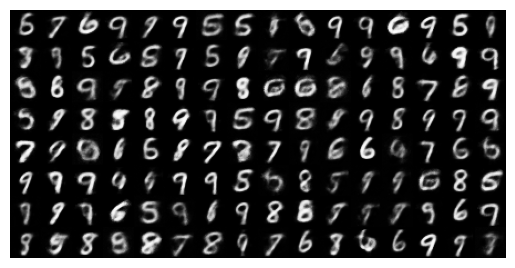

In [ ]:
Xh_batch, _, _, _ = model(X_batch.view(-1, 784).to(device))

plt.imshow(
    torch.permute(make_grid(Xh_batch.detach().cpu().view(-1, 1, 28, 28), nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

### Train with `lower_bound`

In [ ]:
model = MGVAE(input_dim=784, hidden_dim=128, latent_dim=32, majority_data=majority_data, N_maj=2048, device=device)
model = model.to(device)
model.pretrain(majority_dl, kl_loss_fn="lower_bound", lr=1e-3, epochs=33, verbose_period=2)
torch.cuda.empty_cache()
model.finetune(minority_dl, kl_loss_fn="lower_bound", ewc_lambda=1e2, lr=1e-3, epochs=221, verbose_period=20)

pre-training starts:


Epoch 0: 100%|██████████| 240/240 [01:19<00:00,  3.04batch/s, kl_loss=2.27, recon_loss=49.5, total=51.8]


tensor(1.0593, device='cuda:0')


Epoch 2: 100%|██████████| 240/240 [01:16<00:00,  3.16batch/s, kl_loss=5.36, recon_loss=28.3, total=33.6]


tensor(1.5837, device='cuda:0')


Epoch 4: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=7.08, recon_loss=24.9, total=32]


tensor(2.1789, device='cuda:0')


Epoch 6: 100%|██████████| 240/240 [01:15<00:00,  3.16batch/s, kl_loss=7.92, recon_loss=23, total=30.9]


tensor(2.7584, device='cuda:0')


Epoch 8: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.38, recon_loss=21.8, total=30.1]


tensor(3.2921, device='cuda:0')


Epoch 10: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.7, recon_loss=21, total=29.7]


tensor(3.7949, device='cuda:0')


Epoch 12: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.77, recon_loss=20.4, total=29.2]


tensor(4.2662, device='cuda:0')


Epoch 14: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.7, recon_loss=19.8, total=28.5]


tensor(4.7130, device='cuda:0')


Epoch 16: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.64, recon_loss=19.5, total=28.1]


tensor(5.1435, device='cuda:0')


Epoch 18: 100%|██████████| 240/240 [01:15<00:00,  3.16batch/s, kl_loss=8.61, recon_loss=19.2, total=27.8]


tensor(5.5653, device='cuda:0')


Epoch 20: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.56, recon_loss=18.9, total=27.5]


tensor(5.9762, device='cuda:0')


Epoch 22: 100%|██████████| 240/240 [01:15<00:00,  3.16batch/s, kl_loss=8.48, recon_loss=18.7, total=27.2]


tensor(6.3743, device='cuda:0')


Epoch 24: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.44, recon_loss=18.8, total=27.2]


tensor(6.7643, device='cuda:0')


Epoch 26: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.37, recon_loss=18.4, total=26.8]


tensor(7.1363, device='cuda:0')


Epoch 28: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.28, recon_loss=18.3, total=26.6]


tensor(7.4995, device='cuda:0')


Epoch 30: 100%|██████████| 240/240 [01:15<00:00,  3.16batch/s, kl_loss=8.26, recon_loss=18.3, total=26.6]


tensor(7.8518, device='cuda:0')


Epoch 32: 100%|██████████| 240/240 [01:15<00:00,  3.17batch/s, kl_loss=8.21, recon_loss=18.2, total=26.4]


tensor(8.1952, device='cuda:0')
finetuning starts:


Epoch 0: 100%|██████████| 24/24 [00:08<00:00,  2.87batch/s, ewc_loss=0.241, kl_loss=11.1, recon_loss=35.2, total=70.4]


tensor(8.2187, device='cuda:0')


Epoch 20: 100%|██████████| 24/24 [00:07<00:00,  3.18batch/s, ewc_loss=8.65, kl_loss=9.2, recon_loss=21.9, total=896]


tensor(8.5905, device='cuda:0')


Epoch 40: 100%|██████████| 24/24 [00:07<00:00,  3.14batch/s, ewc_loss=18.3, kl_loss=9.31, recon_loss=20.5, total=1.86e+3]


tensor(8.9474, device='cuda:0')


Epoch 60: 100%|██████████| 24/24 [00:07<00:00,  3.19batch/s, ewc_loss=29.2, kl_loss=9.41, recon_loss=19.5, total=2.95e+3]


tensor(9.3093, device='cuda:0')


Epoch 80: 100%|██████████| 24/24 [00:07<00:00,  3.15batch/s, ewc_loss=41, kl_loss=9.36, recon_loss=18.9, total=4.12e+3]


tensor(9.6537, device='cuda:0')


Epoch 100: 100%|██████████| 24/24 [00:07<00:00,  3.20batch/s, ewc_loss=53.4, kl_loss=9.52, recon_loss=18.4, total=5.37e+3]


tensor(9.9763, device='cuda:0')


Epoch 120: 100%|██████████| 24/24 [00:07<00:00,  3.14batch/s, ewc_loss=66.5, kl_loss=9.5, recon_loss=18.3, total=6.68e+3]


tensor(10.2762, device='cuda:0')


Epoch 140: 100%|██████████| 24/24 [00:07<00:00,  3.19batch/s, ewc_loss=80.6, kl_loss=9.53, recon_loss=17.7, total=8.09e+3]


tensor(10.5650, device='cuda:0')


Epoch 160: 100%|██████████| 24/24 [00:07<00:00,  3.13batch/s, ewc_loss=95.2, kl_loss=9.7, recon_loss=17.5, total=9.55e+3]


tensor(10.8362, device='cuda:0')


Epoch 180: 100%|██████████| 24/24 [00:07<00:00,  3.19batch/s, ewc_loss=111, kl_loss=9.77, recon_loss=17.4, total=1.11e+4]


tensor(11.0931, device='cuda:0')


Epoch 200: 100%|██████████| 24/24 [00:07<00:00,  3.13batch/s, ewc_loss=127, kl_loss=9.79, recon_loss=17.1, total=1.27e+4]


tensor(11.3289, device='cuda:0')


Epoch 220: 100%|██████████| 24/24 [00:07<00:00,  3.21batch/s, ewc_loss=143, kl_loss=9.81, recon_loss=16.9, total=1.43e+4]

tensor(11.5538, device='cuda:0')


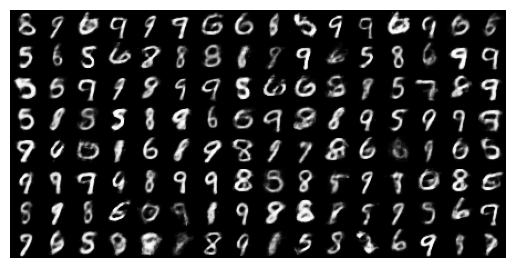

In [ ]:
Xh_batch, _, _, _ = model(X_batch.view(-1, 784).to(device))

plt.imshow(
    torch.permute(make_grid(Xh_batch.detach().cpu().view(-1, 1, 28, 28), nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

In [ ]:
torch.cuda.empty_cache()